In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../features/')
from rule_based_churn import *

In [2]:
#Define data path and load data
data_path = "../data/"

df = pd.read_csv(data_path+'sub_df.csv')
df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-12-04,2017-12-19,728963,537935,78.53235,17,by phone,8281
1,2019-06-18,2019-06-18,153024,720868,236.65528,41,at the store,10891
2,2019-04-24,2019-04-24,63638,1099886,29.55960,9,at the store,4471
3,2018-02-21,2018-02-21,2452526,1904292,117.53460,9,online,5489
4,2019-01-16,2019-02-07,1094311,513380,651.85680,3,by phone,9220


## Rule Based Model

First, we group our dataset by client_id and by order_date. Then we add a new column called "order_number" that counts the number of order for each client. If an order has been done on the same day, for the same client_id, we consider that it is the same order and the order_number stays the same.

In addition, we drop the lines with clients having only placed 1 order because we do not consider them as regulars clients and do not want to tke them into consideration when predicting churn.

In [3]:
df_grouped = count_orders_per_client(df)
df_grouped.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number
1050002,2017-09-26,2017-09-27,2310611,14,160.135200,3,online,10319,1
1814466,2017-09-26,2017-09-26,2927672,14,105.763200,3,online,10319,1
1392104,2017-09-27,2017-10-18,107124,14,372.454333,13,by phone,10319,2
518047,2017-10-02,2017-10-09,738349,14,1.628400,3,by phone,10319,3
1303508,2017-10-03,2017-10-03,1095180,14,199.078800,3,by phone,10319,4


Next, we compute the time difference between orders for a client. We calculate this column in terms of days and we it will later be used to calaculate the frequency of purchasig for a specific client, which will be the base of how we define churn.

In [7]:
time_dif = compute_time_difference_between_orders(df_grouped)
time_dif.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number,time_diff
1050002,2017-09-26,2017-09-27,2310611,14,160.135200,3,online,10319,1,0.0
1814466,2017-09-26,2017-09-26,2927672,14,105.763200,3,online,10319,1,0.0
1392104,2017-09-27,2017-10-18,107124,14,372.454333,13,by phone,10319,2,1.0
518047,2017-10-02,2017-10-09,738349,14,1.628400,3,by phone,10319,3,5.0
1303508,2017-10-03,2017-10-03,1095180,14,199.078800,3,by phone,10319,4,1.0


Next, we compute the average time difference between two consecutive orders for each client in the input DataFrame. First, we group the DataFrame by client_id, then we calculate the time difference between consecutive orders, and finally we can calculate **the mean and standard deviation of the time differences for each client**. This function allows us to return a new DataFrame with the mean and standard deviation time differences, joined with the original DataFrame.

In [8]:
df_mean_time = compute_mean_time_diff(time_dif)
df_mean_time.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number,time_diff,mean_time_diff,std_time_diff
0,2017-09-26,2017-09-27,2310611,14,160.135200,3,online,10319,1,0.0,1.81,2.33
1,2017-09-26,2017-09-26,2927672,14,105.763200,3,online,10319,1,0.0,1.81,2.33
2,2017-09-27,2017-10-18,107124,14,372.454333,13,by phone,10319,2,1.0,1.81,2.33
3,2017-10-02,2017-10-09,738349,14,1.628400,3,by phone,10319,3,5.0,1.81,2.33
4,2017-10-03,2017-10-03,1095180,14,199.078800,3,by phone,10319,4,1.0,1.81,2.33


Now, we create a rule based model that will flag clients that have churned and raise a warning for the one that are about to do so. With this function, we use statistical distributions and probabilities to compute the upper thresholds and warnings, and we use these thresholds for the classification itself, based on a set of rules that compare the time since the last order with the thresholds and warning levels. 

To flag churn, we assume that the time difference between orders follows a **normal distribution**. Therefore, we can use the mean and standard deviation of this distribution to set thresholds, which will help us **identify clients who may be at risk of churning**.

To calculate the thresholds, we first calculate the mean and standard deviation of the time difference between orders for each client. Based on the normal distribution assumption, we calculate the upper and lower thresholds for each client.

The **upper threshold** is calculated by adding a certain number of standard deviations to the mean time difference. The number of standard deviations is determined by the confidence level we choose. By default, we choose a confidence level of **0.99**, so we calculate the upper threshold as the mean time difference plus 2.576 standard deviations. This means that there is a 99% probability that the time difference between orders for a given client will be below this threshold.

The lower threshold is calculated in the same way, but we subtract a certain number of standard deviations from the mean time difference.

We also set **warning levels** to identify clients who may be at **risk of churning in the near future**. These warning levels are calculated in the same way as the thresholds, but using a lower confidence level. by default, we choose a warning level of **0.95**, and we calculated the upper warning as the mean time difference plus 1.96 standard deviations. This means that there is a 95% probability that the time difference between orders for a given client will be below this warning level, but above the upper threshold.

Finally, we use these thresholds to flag the customers as "good," "careful," or "churned" based on a set of rules. The churn_flag is being determined based on the time_since_last_order for each client. 
- If the time_since_last_order is **greater** than the upper_threshold, then the client is considered to have **churned** and the churn_flag is set to "churn". 
- If the time_since_last_order is **less than** or equal to the upper_threshold but **greater** than the upper_warning, then the client is considered to be at **risk of churning** and the churn_flag is set to "careful". 
- If the time_since_last_order is less than or equal to the upper_warning, then the client is considered to be a **loyal customer** and the churn_flag is set to "good".

In [12]:
df_churned = compute_churn_flag(df_mean_time)
df_churned

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number,time_diff,mean_time_diff,std_time_diff,upper_threshold,lower_threshold,upper_warning,lower_warning,time_since_last_order,churn_flag
400,2019-09-20,2019-09-20,3137129,14,0.00000,3,by phone,10319,248,7.0,1.81,2.33,7.811682,-4.191682,6.376716,-2.756716,2.0,good
472,2019-08-30,2019-08-30,1784562,18,0.00000,5,at the store,6654,63,3.0,9.54,8.90,32.464881,-13.384881,26.983679,-7.903679,23.0,good
474,2017-11-15,2017-11-15,641074,37,31.48700,5,at the store,358,2,1.0,0.50,0.71,2.328839,-1.328839,1.891574,-0.891574,676.0,churn
480,2019-08-21,2019-08-21,2899606,40,107.94360,3,at the store,2235,5,2.0,88.67,133.93,433.650819,-256.310819,351.167976,-173.827976,32.0,good
491,2018-11-21,2018-11-21,2778969,56,188.78400,3,at the store,5579,9,50.0,35.55,34.69,124.905519,-53.805519,103.541151,-32.441151,305.0,churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870308,2019-09-09,2019-09-09,774680,2274299,8.52840,3,by phone,5616,60,11.0,5.92,10.33,32.528317,-20.688317,26.166428,-14.326428,13.0,good
1870319,2019-07-19,2019-07-19,1567289,2274322,65.41200,3,at the store,9909,10,4.0,57.27,56.18,201.980090,-87.440090,167.380777,-52.840777,65.0,good
1870322,2019-04-25,2019-04-25,2100209,2274336,107.30880,3,at the store,379,3,141.0,138.33,137.02,491.270131,-214.610131,406.884265,-130.224265,150.0,good
1870337,2019-06-04,2019-06-04,2030665,2274410,36.98400,201,at the store,2708,14,0.0,37.33,36.78,132.069002,-57.409002,109.417475,-34.757475,110.0,careful


Finally, we plot our results.

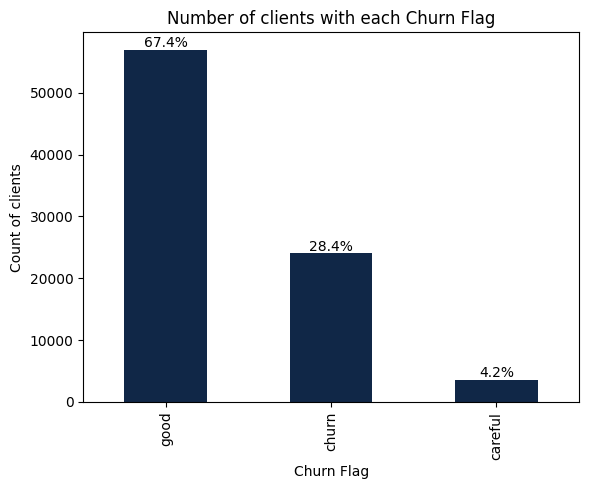

In [15]:
#Plot results
churn_counts = df_churned['churn_flag'].value_counts()

## create the bar plot
fig, ax = plt.subplots()
churn_counts.plot(kind='bar', ax=ax, color="#102747")

## add the percentage labels
for patch in ax.patches:
    height = patch.get_height()
    percent = 100 * height / churn_counts.values.sum()
    ax.annotate(f'{percent:.1f}%', (patch.get_x() + patch.get_width() / 2, height), ha='center', va='bottom')

## set labels and title
ax.set_xlabel('Churn Flag')
ax.set_ylabel('Count of clients')
ax.set_title('Number of clients with each Churn Flag')
plt.savefig('RuleBasedModel_output')
plt.show()